# Run relative vegetation change for IEM CMIP5 ALFRESCO outputs

This notebooks orchestrates the computation of relative vegetation change using the `https://github.com/ua-snap/alfresco_postprocessing/bin/alfresco_relative_vegetation_change.py` script and slurm.

To run this processing, that script must be present on the system and the path to it should be stored in the `REL_VEG_SCRIPT_PATH` variable. 

The path to write the new relative vegetation data should be stored in `OUTPUT_DIR` and the main directory containing the ALFRESCO outputs (currently `/workspace/Shared/Tech_Projects/Alaska_IEM/project_data/Final_runs/IEM_AR5`) should be stored in the `BASE_DIR` environment variable. The `SCRATCH_DIR` variable should specify the path where a folder containing the `sbatch` scripts and slurm output scripts will be written.

Any of these may be set in the code cell below as well. 

In [2]:
import os
from pathlib import Path
from itertools import product


# user paramater, wipe slurm dir if True
wipe_slurm = False

# setup paths
# set path to relative flammability script
rel_veg_fp = Path(os.getenv("REL_VEG_SCRIPT_PATH") or "/workspace/UA/kmredilla/alfresco_postprocessing/bin/alfresco_relative_vegetation_change.py")
# thesse are also available on Poseidon currently but there could be some read savings 
base_dir = Path(os.getenv("BASE_DIR") or "/workspace/Shared/Tech_Projects/Alaska_IEM/project_data/Final_runs/IEM_AR5")
output_dir = Path(os.getenv("OUTPUT_DIR") or "/atlas_scratch/kmredilla/aalfresco")
scratch_dir = Path(os.getenv("SCRATCH_DIR") or "/atlas_scratch/kmredilla/aalfresco")

print("Base dir: ", base_dir)
print("Output dir: ", output_dir)
print("Scratch dir: ", scratch_dir)

relveg_dir = output_dir.joinpath("relative_vegetation_change")
relveg_dir.mkdir(exist_ok=True, parents=True)
# folder for slurm scripts in $SCRATCH
slurm_dir = scratch_dir.joinpath("veg_slurm")
slurm_dir.mkdir(exist_ok=True, parents=True)
if wipe_slurm:
    _ = [fp.unlink() for fp in slurm_dir.glob("*vegetation*")]

Base dir:  /workspace/Shared/Tech_Projects/Alaska_IEM/project_data/Final_runs/IEM_AR5
Output dir:  /atlas_scratch/kmredilla/aalfresco
Scratch dir:  /atlas_scratch/kmredilla/aalfresco


Define a function for writing the `sbatch` commands to `.slurm` scripts:

In [2]:
def write_sbatch(ncpus, slurm_email, slurm_dir, ac_conda_env, relveg_fp, relveg_args):
    """Write the SBATCH `.slurm` scripts for each model/season regression
    
    Args:
        ncpus (int): number of cpus to allocate per job
        slurm_email (str): email address for sending slurm messages
        slurm_dir (PosixPath): path to directory to write sbatch .slurm files
        ac_conda_env (str): name of the conda env that has anaconda-project installed
        relflam_fp (PosixPath): path to script for processing the relative flammability
        relflam_args (dict): dictionary containing args for the relative flammability 
            processing script
        
    Returns:
        filepath of `.slurm` script 
    """
    out_fp = relveg_args["out_fp"]
    head = (
        "#!/bin/sh\n"
        + "#SBATCH --nodes=1\n"
        + f"#SBATCH --cpus-per-task={ncpus}\n"
        + "#SBATCH --account=snap\n"
        + "#SBATCH --mail-type=FAIL\n"
        + f"#SBATCH --mail-user={slurm_email}\n"
        + f"#SBATCH --output={slurm_dir}/{out_fp.name.replace('.tif', '_slurm_%j.out')}\n"
        + "#SBATCH -p main\n\n"
    )
    
    args = (
        # print start time
        "echo Start slurm && date\n"
        # initialize shell to use conda, 
        'eval "$(conda shell.bash hook)"\n'
        # activate env with anaconda-project installed
        f"conda activate {ac_conda_env}\n"
        # call the python regression script
        f"python {relveg_fp} "
        f"-p {relveg_args['maps_dir']} "
        f"-o {out_fp} "
        # just use the number of cores allocated for slurm
        f"-nc {ncpus} "
        f"-by {relveg_args['begin_year']} "
        f"-ey {relveg_args['end_year']}"
    )
    
    slurm_fp = slurm_dir.joinpath(out_fp.name.replace(".tif", ".slurm"))
    with open(slurm_fp, "w") as f:
        f.write(head + args)

    return slurm_fp

### Historical eras

For the historical eras, need to execute a bit differently - since all models have identical outputs for this period, just need to run one model (any) and scenario (any).

In [8]:
def make_sbatch_scripts(relveg_args_list, ncpus, slurm_email, ac_conda_env, rel_veg_fp):
    """Create the sbatch scripts for each of the argument sets in relflam_args_list"""
    slurm_fps = [
        write_sbatch(
            ncpus, slurm_email, slurm_dir, ac_conda_env, rel_veg_fp, args
        ) 
        for args in relveg_args_list
    ]

    print(f"{len(slurm_fps)} slurm scripts written to {slurm_dir}")
    
    return slurm_fps

Create the list of args for historical relative vegetation change jobs:

In [4]:
historical_eras = ["1950-2008"]
historical_eras.extend([f"19{i}0-19{i}9" for i in range(5, 10)])
historical_eras.append("2000-2008")

historical_models = ["GFDL-CM3"]
historical_scenarios = ["rcp45"]

historical_relveg_args_list = []
for era, model, scenario in product(historical_eras, historical_models, historical_scenarios):
    temp_out_fn = f"alfresco_relative_vegetation_change_{era}_historical.tif"
    temp_maps_dir = base_dir.joinpath(f"{model}_{scenario}/Maps")
    begin_year, end_year = era.split("-")

    # relative flammability script args
    historical_relveg_args_list.append({
        "maps_dir": temp_maps_dir,
        "out_fp": relveg_dir.joinpath(temp_out_fn),
        "begin_year": begin_year,
        "end_year": end_year,
    })

Set the sbatch options for all jobs:

In [6]:
# slurm args

# number of cores
ncpus = 32
# slurm email
slurm_email = "kmredilla@alaska.edu"
# name of the conda env that has anaconda-project installed
ac_conda_env = "/home/UA/kmredilla/miniconda3/envs/py38"

Make the sbatch scripts:

In [10]:
historical_slurm_fps = make_sbatch_scripts(historical_relveg_args_list, ncpus, slurm_email, ac_conda_env, rel_veg_fp)
_ = [print(fp.name) for fp in historical_slurm_fps]

7 slurm scripts written to /atlas_scratch/kmredilla/aalfresco/veg_slurm
alfresco_relative_vegetation_change_1950-2008_historical.slurm
alfresco_relative_vegetation_change_1950-1959_historical.slurm
alfresco_relative_vegetation_change_1960-1969_historical.slurm
alfresco_relative_vegetation_change_1970-1979_historical.slurm
alfresco_relative_vegetation_change_1980-1989_historical.slurm
alfresco_relative_vegetation_change_1990-1999_historical.slurm
alfresco_relative_vegetation_change_2000-2008_historical.slurm


### Future eras

For future eras, doing all combinations of model / scenario / era. Setup the args:

In [63]:
# iterate over remaining model / scenario / periods and setup args for processing
eras = [f"20{i}0-20{i}9" for i in range(1, 10)]
models = ["GFDL-CM3", "NCAR-CCSM4", "GISS-E2-R", "IPSL-CM5A-LR", "MRI-CGCM3"]
scenarios = ["rcp45", "rcp60", "rcp85"]

relveg_args_list = []
for era, model, scenario in product(eras, models, scenarios):
    temp_out_fn = f"alfresco_relative_vegetation_change_{era}_{model}_{scenario}.tif"
    temp_maps_dir = base_dir.joinpath(f"{model}_{scenario}/Maps")
    begin_year, end_year = era.split("-")
    
    # relative flammability script args
    relveg_args_list.append({
        "maps_dir": temp_maps_dir,
        "out_fp": relveg_dir.joinpath(temp_out_fn),
        "begin_year": begin_year,
        "end_year": end_year,
    })

In [44]:
slurm_fps = make_sbatch_scripts(relveg_args_list, ncpus, slurm_email, ac_conda_env, rel_veg_fp)
_ = [print(fp.name) for fp in slurm_fps[:10]]

135 slurm scripts written to /atlas_scratch/kmredilla/aalfresco/veg_slurm
alfresco_relative_vegetation_change_2010-2019_GFDL-CM3_rcp45.slurm
alfresco_relative_vegetation_change_2010-2019_GFDL-CM3_rcp60.slurm
alfresco_relative_vegetation_change_2010-2019_GFDL-CM3_rcp85.slurm
alfresco_relative_vegetation_change_2010-2019_NCAR-CCSM4_rcp45.slurm
alfresco_relative_vegetation_change_2010-2019_NCAR-CCSM4_rcp60.slurm
alfresco_relative_vegetation_change_2010-2019_NCAR-CCSM4_rcp85.slurm
alfresco_relative_vegetation_change_2010-2019_GISS-E2-R_rcp45.slurm
alfresco_relative_vegetation_change_2010-2019_GISS-E2-R_rcp60.slurm
alfresco_relative_vegetation_change_2010-2019_GISS-E2-R_rcp85.slurm
alfresco_relative_vegetation_change_2010-2019_IPSL-CM5A-LR_rcp45.slurm


### Submit all sbatch scripts

Submit all historical and future sbatch scripts:

In [14]:
# Call the slurm scripts with the `sbatch` command
_ = [os.system(f"sbatch {fp}") for fp in slurm_fps + historical_slurm_fps]

## Compute 5 model averages

Compute 5 model averages for all new future data.

In [4]:
import rasterio as rio
import numpy as np
from tqdm.notebook import tqdm_notebook

In [64]:
# get rasterio file metadata and mask from any complete file
relveg_fps = list(relveg_dir.glob("*"))
with rio.open(relveg_fps[0]) as src:
    meta = src.meta.copy()
    mask = src.read(1) == -9999
meta.update(compress='lzw')

In [5]:
# setup helper function for reading data from a tif
def read_tif(fp):
    with rio.open(fp) as src:
        arr = src.read(1)
    return arr

In [65]:
# iterate over eras, scenarios and average over models and save new rasters
mean_fps = []
avg_groups = list(product(eras, scenarios))
for era, scenario in tqdm_notebook(avg_groups):
    temp_fps = sorted(list(relveg_dir.glob(f"*{era}*{scenario}*.tif")))
    arrs = [read_tif(fp) for fp in temp_fps]
    mean_arr = np.round(np.array(arrs).mean(axis=0).astype(np.float32), 4)
    # sorted list will return GFDL-CM3 data as first file
    temp_fn = temp_fps[0].name.replace("GFDL-CM3", "5modelAvg")
    temp_out_fp = relveg_dir.joinpath(temp_fn)
    mean_fps.append(temp_out_fp)
    with rio.open(temp_out_fp, "w", **meta) as dst:
        dst.write(mean_arr, 1)

print(f"{len(mean_fps)} 5 model average files written to {relveg_dir}.")
_ = [print(fp.name) for fp in sorted(list(relveg_dir.glob("*5modelAvg*")))[:10]]

  0%|          | 0/27 [00:00<?, ?it/s]

27 5 model average files written to /atlas_scratch/kmredilla/aalfresco/relative_vegetation_change.
alfresco_relative_vegetation_change_2010-2019_5modelAvg_rcp45.tif
alfresco_relative_vegetation_change_2010-2019_5modelAvg_rcp60.tif
alfresco_relative_vegetation_change_2010-2019_5modelAvg_rcp85.tif
alfresco_relative_vegetation_change_2020-2029_5modelAvg_rcp45.tif
alfresco_relative_vegetation_change_2020-2029_5modelAvg_rcp60.tif
alfresco_relative_vegetation_change_2020-2029_5modelAvg_rcp85.tif
alfresco_relative_vegetation_change_2030-2039_5modelAvg_rcp45.tif
alfresco_relative_vegetation_change_2030-2039_5modelAvg_rcp60.tif
alfresco_relative_vegetation_change_2030-2039_5modelAvg_rcp85.tif
alfresco_relative_vegetation_change_2040-2049_5modelAvg_rcp45.tif


## Add non-modeled pixels to nodata mask

Some of the pixels are not modeled and the way that the post-processing scripts compute the summaries assigns these pixels a seemingly-valid data value of 0. These should be masked to nodata, and we will do that here instead of modifying the postprocessing scripts.

**Note** - this will modify the outputs from the above processing in place!

Get a mask of 0-valued cells in the vegetation data. A value of 0 corresponds to non-modeled.

In [1]:
import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
from rasterio.plot import show

In [6]:
# veg output file for deriving new mask from 
veg_fp = list(base_dir.glob("GFDL-CM3_rcp45/Maps/1901/Veg*.tif"))[0]
# get mask from any veg file and include 0 as masking value
with rio.open(veg_fp) as src:
    arr = src.read(1)
mask = (arr == 255) | (arr == 0)

Re-mask the data in parallel:

In [7]:
def mask_tif(args):
    fp, mask = args
    with rio.open(fp, "r+") as src:
        arr = src.read(1)
        arr[mask] = -9999
        src.write(arr, 1)

In [8]:
args = [(fp, mask) for fp in relveg_dir.glob("*.tif")]
with Pool(32) as pool:
    _ = [result for result in tqdm.tqdm(pool.imap_unordered(mask_tif, args), total=len(args))]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:03<00:00, 46.30it/s]


Check some results:

File: /atlas_scratch/kmredilla/aalfresco/relative_vegetation_change/alfresco_relative_vegetation_change_2040-2049_5modelAvg_rcp60.tif


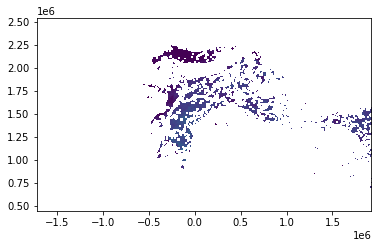

In [9]:
fp = args[np.random.randint(len(args))][0]
print(f"File: {fp}")
with rio.open(fp) as src:
    show(src)

File: /atlas_scratch/kmredilla/aalfresco/relative_vegetation_change/alfresco_relative_vegetation_change_2070-2079_GISS-E2-R_rcp45.tif


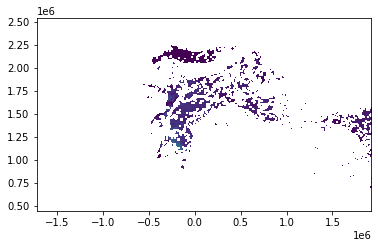

In [10]:
fp = args[np.random.randint(len(args))][0]
print(f"File: {fp}")
with rio.open(fp) as src:
    show(src)

Looks good.

## Package files for rasdaman

Split the files up for ingestion into two different (historical and future) rasdaman coverages:

In [11]:
!mkdir -p /atlas_scratch/kmredilla/aalfresco/historical_relative_vegetation_change
!cp /atlas_scratch/kmredilla/aalfresco/relative_vegetation_change/*historical* /atlas_scratch/kmredilla/aalfresco/historical_relative_vegetation_change

In [12]:
ls -l /atlas_scratch/kmredilla/aalfresco/historical_relative_vegetation_change

total 45928
-rw-r--r--. 1 kmredilla snap_users 6067970 Feb 18 10:33 alfresco_relative_vegetation_change_1950-1959_historical.tif
-rw-r--r--. 1 kmredilla snap_users 8512558 Feb 18 10:33 alfresco_relative_vegetation_change_1950-2008_historical.tif
-rw-r--r--. 1 kmredilla snap_users 6192421 Feb 18 10:33 alfresco_relative_vegetation_change_1960-1969_historical.tif
-rw-r--r--. 1 kmredilla snap_users 6278902 Feb 18 10:33 alfresco_relative_vegetation_change_1970-1979_historical.tif
-rw-r--r--. 1 kmredilla snap_users 6212386 Feb 18 10:33 alfresco_relative_vegetation_change_1980-1989_historical.tif
-rw-r--r--. 1 kmredilla snap_users 6741961 Feb 18 10:33 alfresco_relative_vegetation_change_1990-1999_historical.tif
-rw-r--r--. 1 kmredilla snap_users 7015734 Feb 18 10:33 alfresco_relative_vegetation_change_2000-2008_historical.tif


In [13]:
rm /atlas_scratch/kmredilla/aalfresco/historical_relative_vegetation_change.zip

In [14]:
!cd /atlas_scratch/kmredilla/aalfresco/ && zip -r historical_relative_vegetation_change.zip historical_relative_vegetation_change

  adding: historical_relative_vegetation_change/ (stored 0%)
  adding: historical_relative_vegetation_change/alfresco_relative_vegetation_change_1950-1959_historical.tif (deflated 21%)
  adding: historical_relative_vegetation_change/alfresco_relative_vegetation_change_1950-2008_historical.tif (deflated 15%)
  adding: historical_relative_vegetation_change/alfresco_relative_vegetation_change_1960-1969_historical.tif (deflated 18%)
  adding: historical_relative_vegetation_change/alfresco_relative_vegetation_change_1970-1979_historical.tif (deflated 18%)
  adding: historical_relative_vegetation_change/alfresco_relative_vegetation_change_1980-1989_historical.tif (deflated 18%)
  adding: historical_relative_vegetation_change/alfresco_relative_vegetation_change_1990-1999_historical.tif (deflated 17%)
  adding: historical_relative_vegetation_change/alfresco_relative_vegetation_change_2000-2008_historical.tif (deflated 17%)


In [15]:
!mkdir -p /atlas_scratch/kmredilla/aalfresco/future_relative_vegetation_change
!cp /atlas_scratch/kmredilla/aalfresco/relative_vegetation_change/*rcp* /atlas_scratch/kmredilla/aalfresco/future_relative_vegetation_change

In [16]:
!ls /atlas_scratch/kmredilla/aalfresco/future_relative_vegetation_change | head -5

alfresco_relative_vegetation_change_2010-2019_5modelAvg_rcp45.tif
alfresco_relative_vegetation_change_2010-2019_5modelAvg_rcp60.tif
alfresco_relative_vegetation_change_2010-2019_5modelAvg_rcp85.tif
alfresco_relative_vegetation_change_2010-2019_GFDL-CM3_rcp45.tif
alfresco_relative_vegetation_change_2010-2019_GFDL-CM3_rcp60.tif


In [17]:
rm /atlas_scratch/kmredilla/aalfresco/future_relative_vegetation_change.zip

In [19]:
!cd /atlas_scratch/kmredilla/aalfresco/ && zip -r future_relative_vegetation_change.zip future_relative_vegetation_change